# Tarefa de laboratório 2

## **Sumário**

*   Análise exploratória
*   Construção do modelo
*   Estimadores de $\sigma^2$
*   Teste de significância da regressão
*   $R^2$ e $R^2_{ajustado}$
*   Testes marginais de significância
*   Teste F parcial
*   Intervalo de confiança para os coeficientes
*   Intervalo de confiança para $E(Y)$

## Análise exploratória

Neste relatório de regressão linear, vamos analisar o conjunto de dados fornecido pelo monitor, ajustar modelos lineares múltiplos, testar a significância do modelo, dos coeficientes, melhorar o modelo e encontrar intervalos de confiança, assim como visto durante as aulas (vamos aplicar a teoria). Então, como bom estatístico, vamos começar pela análise exploratória dos dados. 

In [ ]:
#Carregando os dados:
dados <- read.csv('data-table-B2.csv', header=T, dec=',')
Y <- dados[,1]
X <- dados[,c(-1)]
n <- length(Y)

Temos que nossas variáveis são:
*   Y: fluxo total de calor (kwatts)
*   X1: insolação (watts/m^2)
*   X2: posição de foco na direção leste (polegadas)
*   X3: posição de foco na direção sul (polegadas)
*   X4: posição de foco na direção norte (polegadas)
*   X5: hora do dia

Ou seja, temos um problema de placas térmicas provavelmente. De qualquer forma, vamos aos gráficos.

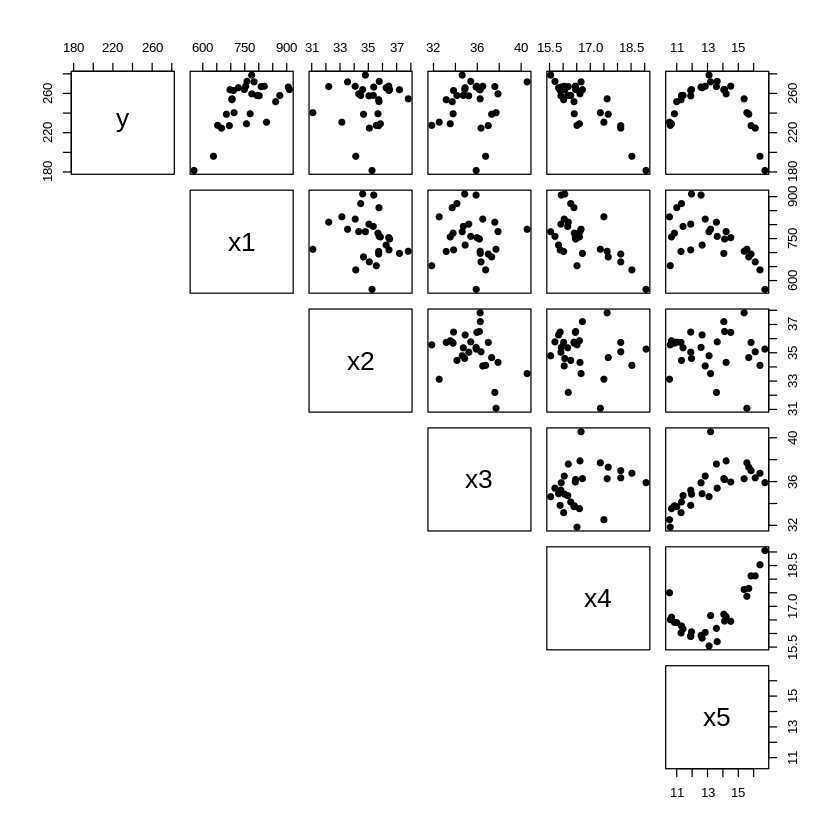

In [ ]:
#Graficos de dispersão:
pairs(dados, pch = 19, lower.panel = NULL)

Em primeiro lugar, vemos que as possíveis variáveis linearmente relacionadas com $Y$ são $X_1$ e $X_4$, e $X_5$ também parece estar relacionada, porém não linearmente, vamos tentar considerar uma transformação.

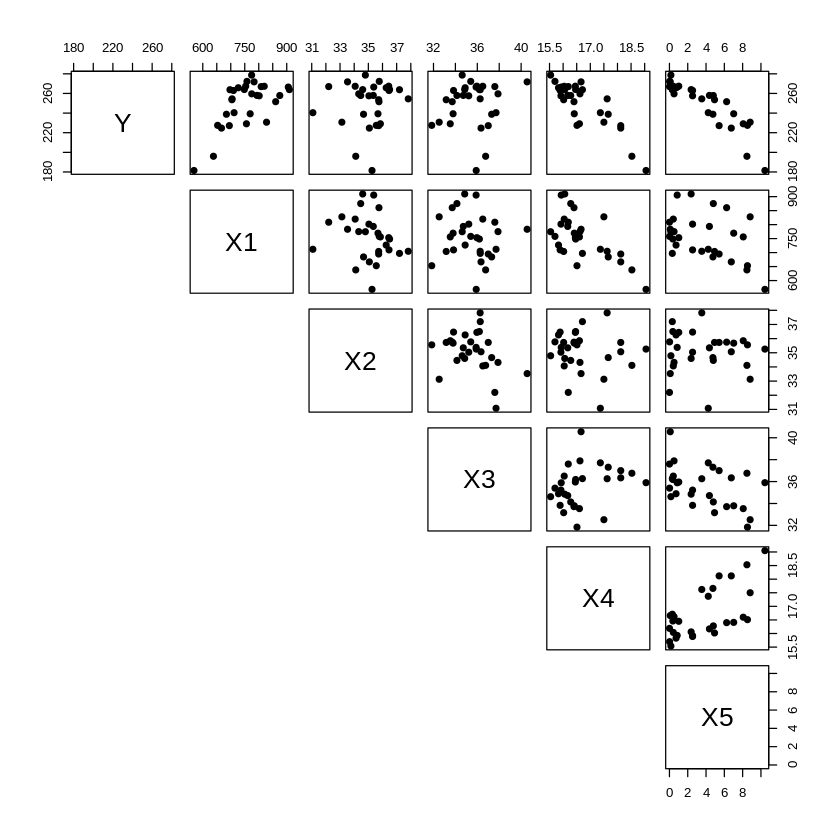

In [ ]:
#Graficos de dispersao, X_5 transformado:
d2 <- cbind(Y=dados[,1], X1 = dados[,2],
            X2=dados[,3], X3=dados[,4],
            X4=dados[,5], X5=(dados[,6]-13.5)^2)
pairs(d2, pch = 19, lower.panel = NULL)

De fato, a relação entre as duas observações melhorou bastante. Porém, veja que, após a mudação, todas as covariáveis parecem estar correlacionadas com $X_5$, o que faz sentido na verdade, pois o sol atinge seu ápice perto das 12hs, dessa forma, é natural que toda a condição do sistema mude para que capte mais calor. Em termos estatísticos, isto pode significar que não teremos muitos dados relevantes, com excessão dos valores de $X_5$, pois eles parecem estar correlacionados.

Em segundo lugar, perceba que $X_2$ e $X_3$ parecem não apresentar relação linear com $Y$, possivelmente, uma indicação de covariáveis que serão não significativas.

Dito isso, vejamos a densidade de cada observação.

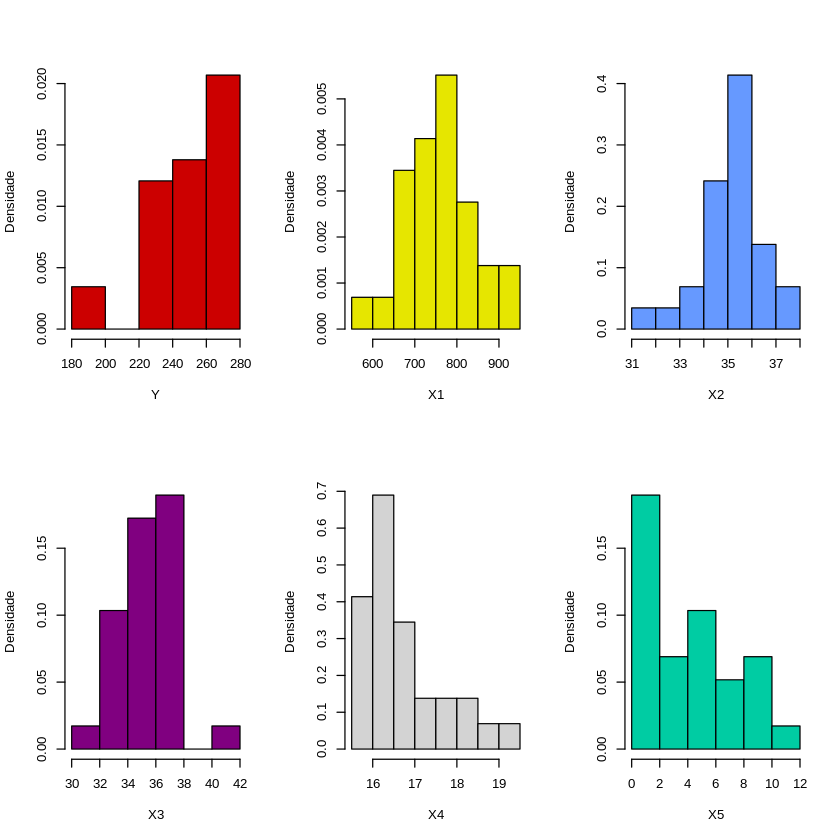

In [ ]:
#Histogramas:
par(mfrow=c(2,3))
hist(d2[,1], xlab='Y', freq=F, main='',
     ylab='Densidade', col='#cc0000')

hist(d2[,2], xlab='X1', freq=F, main='',
     ylab='Densidade', col='#e6e600')

hist(d2[,3], xlab='X2', freq=F, main='',
     ylab='Densidade', col='#6699ff')

hist(d2[,4], xlab='X3', freq=F, main='',
     ylab='Densidade', col='#800080')

hist(d2[,5], xlab='X4', freq=F, main='',
     ylab='Densidade')

hist(d2[,6], xlab='X5', freq=F, main='',
     ylab='Densidade', col='#00cca3')

Parece correto dizer que tanto $X_1$ quanto $X_2$ estão normalmente distribuídas, mas apenas elas, $X_3$ e $X_4$ parece obedecer uma distribuição gama, $X_5$ é até difícil comentar, pois a distribuição parece trimodal e não conhecemos alguma expressão que combine. E por último, e talvez mais importante, $Y$ não parece apresentar distribuição normal, o que pode gerar grandes erros para o nosso modelo, visto que vamos assumir que o erro é normalemente distrbuído.

Entretanto, vamos continuar e analisar a presença de _outliers_ agora.

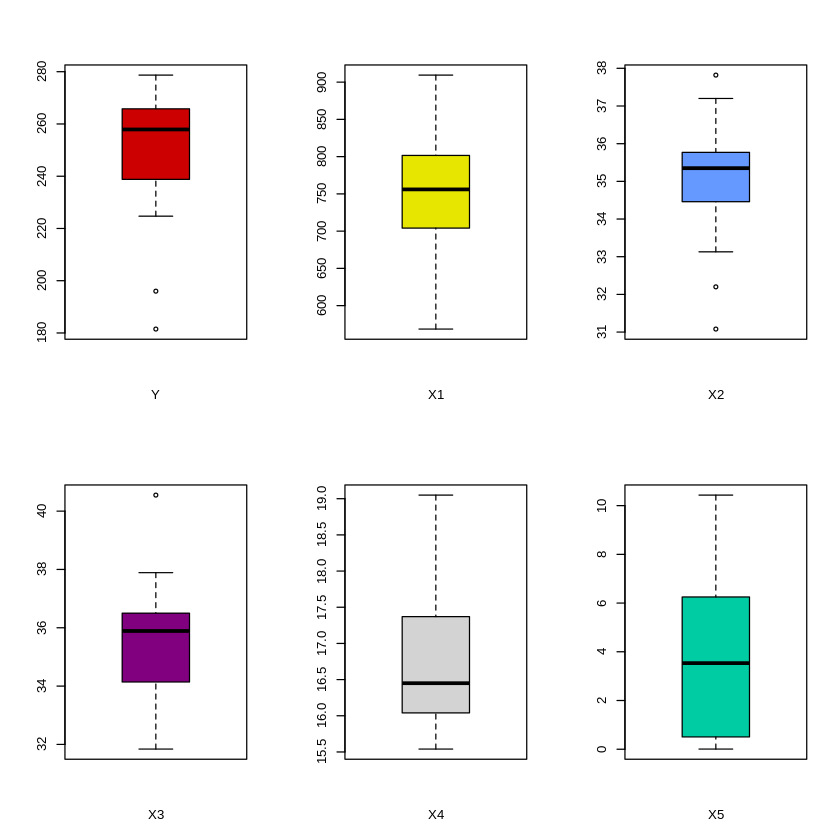

In [ ]:
#Boxplots:
par(mfrow=c(2,3))
boxplot(d2[,1], xlab='Y',
        main='', col='#cc0000')

boxplot(d2[,2], xlab='X1',
        main='', col='#e6e600')

boxplot(d2[,3], xlab='X2',
        main='', col='#6699ff')

boxplot(d2[,4], xlab='X3',
        main='', col='#800080')

boxplot(d2[,5], xlab='X4', main='')

boxplot(d2[,6], xlab='X5',
        main='', col='#00cca3')

Então, uma das nossas maiores preocupações eram os _outliers_, quando vimos os gráficos de dispersão parecia haver alguns, e de fato, parecem haver alguns, mas eles estão rasoavelmente próximos dos limites das caudas (e não acreditamos que aos quatros pontos com posição de foco muito diferentes conseguirão influenciar o modelo). No máximo, talvez os dois pontos distantes no _boxplot_ de $Y$ diminuirão um pouco as medidas de adequabilidade, caso achemos necessário, possamos retirá-los das contas.

Portanto, concluímos a análise exploratória com grandes esperenças de que um modelo linear se ajuste bem aos dados, sendo esperado que, pelo menos, $X_4$ e $X_5$ sejam significativas.

## Construção do modelo com todas as covariáveis

Terminada a análise exploratória dos dados, a partir de agora, começaremos a aplicar a teoria vista em aula, partindo da construção de um modelo com todas as covariáveis disponíveis já nesta seção.

Vamos montar a matrizes $\bf{X}$ e $Y$, considerando a transformação em $X_5$, como dito durante a seção anterior, e que o erro da predição tem distribuição normal com média zero e variância $\sigma^2$.

In [ ]:
# Matrizes
Ym <- matrix(Y)
k <- length(X)
p <- k + 1
Xm <- matrix(c(rep(1,n), X$x1, X$x2, X$x3, X$x4, (X$x5-13.5)^2),
             ncol=p, byrow=F)

# Matriz X^t * X:
xtx = t(Xm)%*%Xm
xtx

29.0000,21879.75,1017.800,1030.350,484.360,108.3007
21879.7500,16685996.45,767258.872,776930.793,364150.133,78745.2407
1017.8000,767258.87,35777.491,36137.578,16995.139,3794.8739
1030.3500,776930.79,36137.578,36703.763,17222.519,3772.3038
484.3600,364150.13,16995.139,17222.519,8112.908,1861.9513
108.3007,78745.24,3794.874,3772.304,1861.951,700.5113


Esta é a matriz com as várias estatísticas de soma das covariáveis, temos o número de observações em $xtx[1,1]$, a soma de cada covariável na primeira linha e na primeira coluna, a soma de cada uma ao quadrado na diagonal e as combinações nos lugares restantes.

In [ ]:
# Matriz (X^t * X)^-1:
xtxinv = solve(xtx)
xtxinv

124.19190365,-2.486349e-02,-1.4973447573,-1.138208e+00,-0.6381069071,-4.684652e-01
-0.02486349,1.080179e-05,0.0001716554,-2.155859e-07,0.0006412083,-3.357959e-06
-1.49734476,1.716554e-04,0.0285446116,2.206858e-02,-0.0279258051,1.294816e-02
-1.13820770,-2.155859e-07,0.0220685820,6.280377e-02,-0.1203250274,3.806169e-02
-0.63810691,6.412083e-04,-0.0279258051,-1.203250e-01,0.3432048866,-8.641974e-02
-0.46846517,-3.357959e-06,0.0129481607,3.806169e-02,-0.0864197434,2.882467e-02


Já nesta matriz, cada valor da diagonal é usado para estimar a variância de cada coeficiente da regressão.

In [ ]:
# Matriz X^t * Y:
xty = t(Xm) %*% Ym 
xty

7239.50
5494127.75
254174.48
257347.61
120420.35
25182.05


Este vetor, por sua vez, nos mostra os resultados das somas: $\sum_{i=1}^n X_{ji} Y_i$, para $j = 0,1,...,k$, sendo $X_0$ o vetor apenas com o valor um (é a primeira coluna de $\bf{X}$). 

In [ ]:
# Estimador de Beta:
betas = xtxinv %*% xty
betas

344.29257586
0.05209557
0.90380373
-0.68041628
-7.45309456
-4.55829390


Por fim, temos o vetor com o valor estimado de $\boldsymbol{\beta}$, logo, nosso primeiro modelo é da forma:

$$\hat{Y} = \boldsymbol{X\hat{\beta}} = 344.29 + 0.05X_1 + 0.90X_2 - 0.68X_3 - 7.45X_4 - 4.56X_5$$

Ademais, como ajustamos um modelo com erro normal, o resultado seria sempre o mesmo, mas se quiséssemos que o erro tivesse outra distribuição, então o método que usamos (mínimos quadrados) não seria adequado, o melhor seria estimar $\boldsymbol{\beta}$ com o método de máxima verossimilhança, que justamente leva em conta a distribuição do erro.

Mas, no nosso caso, feita a transformação em $X_5$, acreditamos que será adequado seguir a teoria vista em aula e considerar o erro com distribuição normal.

## Estimadores de $\sigma^2$

Então já encontramos os estimadores dos coeficientes da regressão, agora, vamos encontrar o estimador da variância, $\sigma^2$, tanto pelo método dos mínimos quadrados quanto pelo método de máxima verossimilhança.

Mas antes, vejamos uma rápida comparação entre os verdadeiros valores de $Y$ e os valores estimados junto com os resíduos.

In [ ]:
Y_est = Xm %*% betas #Y's estimados
res = Ym - Y_est #residuos
tab<- rbind.data.frame( cbind.data.frame(Y=Y, Y_estimado=Y_est, Residuos=res),
                 Total = c(sum(Y), sum(Y_est), sum(res)),
                 Media = c(sum(Y)/n, sum(Y_est)/n, sum(res)/n))

rownames(tab) = c(seq(1,n,1), 'Total', 'Média')
tab

,Y,Y_estimado,Residuos
,<dbl>,<dbl>,<dbl>
1,271.8000,263.2365,8.563501e+00
2,264.0000,267.2740,-3.274000e+00
3,238.8000,232.6044,6.195590e+00
4,230.7000,224.5958,6.104239e+00
5,251.6000,247.7723,3.827727e+00
6,257.9000,254.6013,3.298733e+00
7,263.9000,268.7228,-4.822847e+00
8,266.5000,276.4382,-9.938220e+00
9,229.1000,232.7771,-3.677089e+00


Perceba que os valores entre observações individuais difere bastante, mas, na média, eles são iguais e os resíduos valem praticamente zero, assim como visto na teoria. Dito isso, vamos encontrar os estimadores de $\sigma^2$, dados por:

$$\begin{equation}
\hat{\sigma}^2_{EMQ} = \frac{SQ_{res}}{n-p} \ \ \ \ (1) \\
\hat{\sigma}^2_{EMV} = \frac{SQ_{res}}{n} \ \ \ \ (2)
\end{equation}$$

In [ ]:
SQres = t(res) %*% (res) #Soma do quadrado dos residuos

sig2_mmq = SQres[1,1]/(n-p) #estimador de sigma^2, minimos quadrados
sig2_emv = SQres[1,1]/n #estimador de sigma^2, maxima verossimilhanca

data.frame(EMQ = sig2_mmq, EMV = sig2_emv)

EMQ,EMV
<dbl>,<dbl>
38.30679,30.38125


Portanto, temos os valores estimados para a variância de $\hat{Y}$, porém, faltou comentar de propriedades importantes sobre os valores. Isto é, dado que é possível provar que $E(SQ_{res}) = (n-p)\sigma^2$ desde que o erro seja normal, então de $(1)$ e $(2)$, temos que:

$$ E(\hat{\sigma}^2_{EMQ}) = \frac{(n-p)\sigma^2}{n-p} = \sigma^2 \\
E(\hat{\sigma}^2_{EMV}) = \frac{(n-p)\sigma^2}{n} \ne \sigma^2
$$

Ou seja, $\hat{\sigma}^2_{EMQ}$ é não enviesado e $\hat{\sigma}^2_{EMV}$ é assintoticamente não enviesado para $\sigma^2$. Além disso, é possível prova que: 
$$\lim_{n\to\infty} P(|\hat{\sigma}^2_{EMV} - \sigma^2| \lt \epsilon) = 1 - \frac{V(\hat{\sigma}^2_{EMV})}{\epsilon^2} = 1 - \frac{V(SQ_{res})}{n^2\epsilon^2} = 1$$

E, dessa forma, $\hat{\sigma}^2_{EMV}$ também é um estimador consistente para $\sigma^2$, desde que o erro seja normalmente distrbuído.

Logo, temos que as estimativas para a variância do modelo, dadas por $38.31$ ou $30.38$, de fato, são boas aproximações.

## Teste de significância da regressão

Já construímos o modelo com todas as covariáveis fornecidas, agora o próximo passo é testar a significância de cada uma. Para isso, primeiro faremos um teste F, i.e., o teste para pelo menos uma covariável significamente, que tenha uma relação linear com a variável resposta. Lembrando que, como visto na primeria seção, já esperamos que $X_4$, $X_5$ transformado e, talvez, $X_1$ apresentem essa relação de linearidade.

Dessa forma, considere: $ \begin{cases}
H_0: \boldsymbol{\beta} = 0 \\
H_1: \beta_i \neq 0, \text{para } \forall{i = 0,1,2,3,4,5.}
\end{cases}$

Então, para o teste, vamos construir a tabela ANOVA e usar a estatística $F_0$, a qual, sob $H_0$, é dada por :

$F_0 = \frac{QM_{reg}}{QM_{res}} \sim F_{(k, n-p)}$.

E, rejeitamos $H_0$, se $F_0 \gt F_{(1-\alpha; \ k,n-p)}$.

Além disso, para o cálculo de $F_0$, precisamos das _somas dos quadrados_ (SQ) e dos _grais de liberdade_ (g.l.) de cada termo.

Assim, temos: $k$ (número de covariáveis do modelo) para os g.l. da regressão, $n-1$ (o número mínimo de observações necessárias, dado que temos a média delas) para os g.l. totais e $n-p$ (pois $n-1=x + k \iff x=n-(1+k)=n-p$) para os g.l. do resíduo.


E cada SQ é da forma:
$$\begin{split}
SQ_t &= \sum_{i=1}^n (Y_i - \bar{Y}_i)^2 \\
SQ_{res} &= \sum_{i=1}^n (e_i)^2 = \bf{e}^t e \\
SQ_{reg} &= SQ_t - SQ_{res}
\end{split}$$

Então, temos a seguinte tabela

In [ ]:
#Construcao da tabela ANOVA
Y_barra = mean(Y)

SQt = sum((Y - Y_barra)^2) #Soma do quadrado total
SQreg = SQt - SQres #Soma do quadrado da regressao

QMres = sig2_mmq #Quadrado medio do residuo
QMreg = SQreg/k #Quadrado medio da regressao
QMt = SQt/(n-1) #Quadrado medio total

F_0 = QMreg/QMres #estatistica do teste

anova <- data.frame(f.v = c('Regressão', 'Resíduo', 'Total'),
                    g.l = c(k, n-p, n-1),
                    SQ = round(c(SQreg, SQres, SQt), 4),
                    QM = c(round(QMreg,4), round(QMres,4), ''),
                    'F' = c(round(F_0, 4), '', '')
                    )
anova

f.v,g.l,SQ,QM,F
<chr>,<dbl>,<dbl>,<chr>,<chr>
Regressão,5,13800.8721,2760.1744,72.0544
Resíduo,23,881.0562,38.3068,
Total,28,14681.9283,,


In [ ]:
#Teste de significancia para pelo menos uma covariavel
teste_f = qf(0.90, k, n-p)

if(F_0 > teste_f){
  cat('Rejeita-se H0.')
}

Rejeita-se H0.

Portanto, pelo teste F, há pelo menos uma covariável significativa no modelo, como o esperado, mas ainda não sabemos qual ou quais são relevantes.

## $R^2$ e $R^2_{ajustado}$

Neste tópico, vamos medir a adequabilidade do modelo a partir do $R^2$ e do $R^2_{ajustado}$, que são dados por:

$$R^2 = \frac{SQ_{reg}}{SQ_t} \\
R^2_{ajustado} = 1 - \frac{QM_{res}}{QM_t}$$

Além disso, saiba que há diferenças entre cada medida: o $R^2$ explica o quanto nosso modelo está se aproximando dos reais valores da variável resposta, sendo sensível a adição de novas covariáveis (ele tende a aumentar mesmo que a covariável não contribua significativamente), já o $R^2_{ajustado}$ mostra o impacto de uma nova variável preditora na diferença média dos resíduos (pois, sendo o $QM_t$ constante para qualquer modelo preditor de $Y$, a medida só aumenta se o $QM_{res}$ diminuir).

Ademais, não vamos medir a variabilidade apenas para o nosso modelo com todas as covariáveis, mas sim para mais três outros modelos também, dados por:

$$\begin{split}
\hat{Y_1} &= \beta_{01} + \beta_{11} X_1 + \beta_{21} X_2 + \beta_{31} X_3 + \beta_{41} X_4 + \beta_{51} X_5 \\
\hat{Y_2} &= \beta_{02} + \beta_{12} X_1 + \beta_{32} X_3 + \beta_{42} X_4 + \beta_{52} X_5 \\
\hat{Y_3} &= \beta_{03} + \beta_{13} X_1 + \beta_{43} X_4 + \beta_{53} X_5 \\
\hat{Y_4} &= \beta_{04} + \beta_{24} X_2 + \beta_{34} X_3 + \beta_{44} X_4
\end{split}$$

Dessa forma, daremos mais importância para os valores do $R^2_{ajustado}$, porque os modelos apenas mudam na quantidade de covariáveis, sem transformações, e queremos começar a entender quais variáveis explanatórias são importantes e necessárias para predizer $Y$. Então, seguimos para a construção de cada modelo.

In [ ]:
#Construcao dos modelos

## modelo 1: ja temos.

## modelo 2:
X2 = Xm[,c(-3)]
p2 = p-1
beta2 = solve( t(X2)%*%X2 )%*%( t(X2)%*%Y )
beta2

391.70277703
0.04666047
-1.37917046
-6.56888400
-4.96826956


In [ ]:
## modelo 3:
X3 = Xm[,c(-3,-4)]
p3 = p2-1
beta3 = solve( t(X3)%*%X3 )%*%( t(X3)%*%Y )
beta3

392.28856734
0.04265258
-9.54584805
-4.12249741


In [ ]:
## modelo 4:
X4 = Xm[,c(-2, -6)]
p4 = p3
beta4 = solve( t(X4)%*%X4 )%*%( t(X4)%*%Y )
beta4

389.165916
2.124745
5.318469
-24.132385


Então, os modelos são da forma:

$$\begin{split}
\hat{Y_1} &= 344.29 + 0.05X_1 + 0.90X_2 - 0.68X_3 - 7.45X_4 - 4.56X_5 \\
\hat{Y_2} &= 391.70 + 0.05X_1 - 1.38X_3 - 6.57X_4 - 4.97X_5 \\
\hat{Y_3} &= 392.29 + 0.04X_1 - 9.55X_4 - 4.12X_5 \\
\hat{Y_4} &= 389.17 + 2.12X_2 + 5.32X_3 - 24.13X_4
\end{split}$$

Agora vamos calcular as medidas de adequabilidade:

In [ ]:
## modelo 1:
R2_1 = SQreg/SQt
R2_aj_1 = 1 - (QMres/QMt)

## modelo 2:
res2 = Y - (X2 %*% beta2)

SQres_2 = t(res2) %*% res2
SQreg_2 = SQt - SQres_2
QMres_2 = SQres_2/(n-p2)

R2_2 = SQreg_2/SQt
R2_aj_2 = 1 - (QMres_2/QMt)

## modelo 3:
res3 = Y - (X3 %*% beta3)

SQres_3 = t(res3) %*% res3
SQreg_3 = SQt - SQres_3
QMres_3 = SQres_3/(n-p3)

R2_3 = SQreg_3/SQt
R2_aj_3 = 1 - (QMres_3/QMt)

## modelo 4:
res4 = Y - (X4 %*% beta4)

SQres_4 = t(res4) %*% res4
SQreg_4 = SQt - SQres_4
QMres_4 = SQres_4/(n-p4)

R2_4 = SQreg_4/SQt
R2_aj_4 = 1 - (QMres_4/QMt)

# tabela resumindo os dados
tab <- data.frame(R2 = round(c(R2_1, R2_2, R2_3, R2_4), 3),
                  R2_aj = round(c(R2_aj_1, R2_aj_2, R2_aj_3, R2_aj_4), 3))

rownames(tab) <- c('mod.1', 'mod.2', 'mod.3', 'mod.4')
tab

,R2,R2_aj
,<dbl>,<dbl>
mod.1,0.940,0.927
mod.2,0.938,0.928
mod.3,0.935,0.927
mod.4,0.874,0.859


Em primeiro lugar, veja que, dado a presença das outras covariáveis, a ausência de $X_2$ não tem impacto nenhum, assim como a ausência de $X_3$, são duas observações que pouco explicam a variabilidade de $Y$. Ou seja, esperamos que os coeficientes $\beta_2$ e $\beta_3$ não passem pelo teste marginal de significância.

Em segundo lugar, veja que o quarto modelo (com $X_2$, $X_3$ e $X_4$) consegue explicar muito da variabilidade de $Y$, provavelmente, devido a presença de $X_4$. Mas veja também que retirar $X_5$ do modelo não foi algo bom, as medidas diminuíram bastante, diferente dos outros modelos, que apresentaram valores sempre muito altos. Dessa forma, vemos a importância de $X_4$ e $X_5$ para a melhor predição possível.

Portanto, temos que pelo menos as covariáveis $X_4$ e $X_5$ serão necessárias para o modelo, enquanto que $X_2$ e $X_3$ não serão, permanecendo a dúvida sobre $X_1$.

## Testes marginais de significância

Visto que o modelo com todas as covariáveis passou pelo teste F (como mostrado anteriormente), então nesta seção, faremos os testes marginais (ou testes T) para cada coeficiente, de forma a determinar quais são de fato significantes.


Assim, considere as hipóteses:
$ 
\begin{cases}
H_0: \beta_i = 0 \\
H_1: \beta_i \neq 0, \text{para i = 0,1,2,3,4,5.}
\end{cases}
$

Então, como visto em aula, sob $H_0$, temos que:

$$ t_{0i} = \frac{ \hat{\beta}_i }{ \sqrt{QM_{res}.(X^t X)^{-1}_{ii}} } = \frac{\hat{\beta}_i}{\hat{dp}(\hat{\beta}_i)} \sim t_{n-p}.$$

E, rejeitamos $H_0$, se $t_{0i} \lt t_{(\frac{\alpha}{2}; n-p)}$ ou $t_{0i} \gt t_{(1-\frac{\alpha}{2}; n-p)}$.

In [ ]:
valor_t <- function(i){
  #Funcao que calcula t_0i.
  #param i: o indice do coef. beta, i = 0,1,2,3,4,5
  return(betas[i+1,1] / sqrt(QMres*xtxinv[i+1,i+1]))
}

#Calculo de t_0i
t_00 = valor_t(0)
t_01 = valor_t(1)
t_02 = valor_t(2)
t_03 = valor_t(3)
t_04 = valor_t(4)
t_05 = valor_t(5)

data.frame(Beta = c(paste('Beta', seq(0,5,1))),
           Est.t = c(t_00, t_01, t_02, t_03, t_04, t_05)
           )

quantil_5 = qt(0.05, n-p)
data.frame(quantil_t_5 = quantil_5,
           quantil_t_95 = -quantil_5)

Beta,Est.t
<chr>,<dbl>
Beta 0,4.9916385
Beta 1,2.5610327
Beta 2,0.8643192
Beta 3,-0.4386761
Beta 4,-2.0555214
Beta 5,-4.3379274


quantil_t_5,quantil_t_95
<dbl>,<dbl>
-1.713872,1.713872


Logo, não rejeitamos $H_0$ apenas para $\beta_2$ e $\beta_3$, i.e., apenas os valores de $X_2$ e $X_3$ são não significantivos dado que já temos as outras covariáveis presentes (o que está de acordo com o esperado). Além disso, o terceiro modelo proposto enquanto analisávamos a adequabilidade é o modelo com todas as variáveis significativas, o que facilitará os próximos testes.

Então, lembrando que o modelo tem a forma:
$$\hat{Y_3} = 392.29 + 0.04X_1 - 9.55X_4 - 4.12X_5.$$
Vamos fazer os mesmos testes marginais apenas para os coeficientes dele.

In [ ]:
SQreg_3 = SQt - SQres_3 # Nova Soma dos quadrados da regressao
QMreg_3 = SQreg_2/(k-2) # Novo Quadrado medio da regressao

sig2_mmq_3 = SQres_3[1,1]/(n - p3) #Novo estimador de sigma^2, minimos quadrados
sig2_emv_3 = SQres_3[1,1]/n #Novo estimador de sigma^2, maxima verossimilhanca

data.frame(Novo_EMQ=sig2_mmq_3, Novo_EMV=sig2_emv_3)

Novo_EMQ,Novo_EMV
<dbl>,<dbl>
38.05027,32.80196


Observe que retirando duas covariáveis, mesmo que não significativs (segundo os testes marginais), ambas as variâncias estimadas aumentaram, pois há menos dados para explicar a variável resposta, logo o erro da predição aumenta, mesmo que pouco. Então, feita a observação, seguimos para os testes.

In [ ]:
aux = solve( t(X3)%*%X3 ) # Nova matriz (X^t * X)^-1
valor_t_3 <- function(i){
  #Funcao que calcula t_0i, para o novo modelo.
  #param i: o indice do coef. beta, i = 0,1,2,3
  return(beta3[i+1,1] / sqrt(QMres_3*aux[i+1,i+1]))
}

# Novos valores de t_0i
t_30 = valor_t_3(0)
t_31 = valor_t_3(1)
t_34 = valor_t_3(2)
t_35 = valor_t_3(3)

data.frame(Novos_Betas = c('B.0', 'B.1', 'B.4', 'B.5'),
           Novas_Est.t = c(t_30, t_31, t_34, t_35)
           )

quantil_5_2 = qt(0.05, n-p2)
data.frame(Novo_quantil_t_5 = quantil_5_2,
           Novo_quantil_t_95 = -quantil_5_2)

Novos_Betas,Novas_Est.t
<chr>,<dbl>
B.0,9.413718
B.1,2.257305
B.4,-4.827432
B.5,-8.814277


Novo_quantil_t_5,Novo_quantil_t_95
<dbl>,<dbl>
-1.710882,1.710882


Portanto, para este novo modelo, rejeitamos $H_0$ para todas as covariáveis, sendo todas elas significativas.

## Teste F parcial

Faça uma análise e escolha do melhor modelo; qual modelo seu grupo acredita ser o melhor? Apresente o modelo escolhido pelo grupo (equação do modelo ajustado, estimativas de $\beta$, $\sigma^2$ e interpretação). Justifique a escolha das covariáveis.

Para esta última seção de testes, resolvemos que a covariável $X_4$ é de fundamental importância para o modelo, pois a variável respota sempre teve uma relação linear com ela, assim, vamos testar a contribuição dos pares $(X_1, X_5)$ e $(X_2, X_3)$ no modelos que já apresentam as outras covariáveis, dessa forma, veremos quais são mais importantes.

Então, primeiramente, precisamos das soma dos quadrados extras devidos a cada par, para isso, considere novamente os quatro modelos criados na seção "$R^2$ e $R^2_{ajustado}$":

$$\begin{split}
\hat{Y_1} &= \beta_{01} + \beta_{11} X_1 + \beta_{21} X_2 + \beta_{31} X_3 + \beta_{41} X_4 + \beta_{51} X_5 \\
\hat{Y_2} &= \beta_{02} + \beta_{12} X_1 + \beta_{32} X_3 + \beta_{42} X_4 + \beta_{52} X_5 \\
\hat{Y_3} &= \beta_{03} + \beta_{13} X_1 + \beta_{43} X_4 + \beta_{53} X_5 \\
\hat{Y_4} &= \beta_{04} + \beta_{24} X_2 + \beta_{34} X_3 + \beta_{44} X_4
\end{split}$$

Logo, considerando a soma dos quadrados extras corrigidos, temos que:

$$\begin{split}
SQ_{reg} &= SQ_{reg}(\beta_{11}, \beta_{21}, \beta_{31}, \beta_{41}, \beta_{51}|\beta_{01}) \\
SQ_{reg}(\beta_1, \beta_5|\beta_0) &= SQ_{reg} - SQ_{res}(\beta_{24}, \beta_{34}, \beta_{44}|\beta_{04}) \\
SQ_{reg}(\beta_2, \beta_3|\beta_0) &= SQ_{reg} - SQ_{res}(\beta_{13}, \beta_{43}, \beta_{53}|\beta_{03})
\end{split}$$

E, assim, $\frac{SQ_{reg}(\beta_1, \beta_5|\beta_0)}{\sigma^2} \sim \chi^2_r \ $ e $\ \frac{SQ_{reg}(\beta_2, \beta_3|\beta_0)}{\sigma^2} \sim \chi^2_r \ $, sendo $r=2$ (a quantidade de coeficientes sendo testados).

In [ ]:
#Soma dos quadrados extra
SQ_b1b5 = SQreg - SQreg_4
SQ_b2b3 = SQreg - SQreg_3

cat('Soma dos quadrados da regressao extras devido a beta_1 e beta_5:')
round(SQ_b1b5[1,1], 4)
cat('Soma dos quadrados da regressao extras devido a beta_2 e beta_3:')
round(SQ_b2b3[1,1], 4)

Soma dos quadrados da regressao extras devido a beta_1 e beta_5:

[1] 967.0053

Soma dos quadrados da regressao extras devido a beta_2 e beta_3:

[1] 70.2005

Apenas comparando os valores, já podemos perceber a diferença de relevância para cada par; para o modelo com $X_1$, $X_4$ e $X_5$, as outras covariáveis são irrelevantes. Então já esperamos que, novamente, apenas $X_1$ e $X_5$ se provem importantes.

Mas vamos continuar com os testes, considere as hipóteses: $\begin{cases}
H_0: (\beta_i,\beta_j) = (0,0) \\
H_1: (\beta_i,\beta_j) \neq (0,0), \text{para (i,j) = (2,3) ou (1,5)}
\end{cases}$

Dessa forma, consideramos a quantidade $F_{ij}$ para o teste, que sob $H_0$ é dada por:

$$F_{ij} = \frac{\frac{SQ_{reg}(\beta_i, \beta_j|\beta_0)}{r} }{\frac{SQ_{res}}{n-p} } = \frac{QM_{reg}(\beta_i,\beta_j|\beta_0)}{QM_{res}} \sim F_{(r=2,n-p)}$$

E, rejeitamos $H_0$, se $F_{ij} \gt F_{(1-\alpha; \ r=2,n-p)}$.

In [ ]:
#Testes:
F_15 = (SQ_b1b5/2)/QMres
F_23 = (SQ_b2b3/2)/QMres

data.frame(F_15=F_15, F_23=F_23)

cat(paste('Quantil da F(2,n-p) 90%:', round(qf(0.90, 2, n-p),4)))

F_15,F_23
<dbl>,<dbl>
12.62185,0.9162931


Quantil da F(2,n-p) 90%: 2.5493

Portanto, vemos que as covariáveis posição de foco na direção sul e leste são irrelevantes nos modelos com as outras covariáveis, e pelos teste anteriores, todas elas são significativas, não sendo aconselhável reduzir ainda mais o modelo. Na verdade, dado que já temos uma posição da direção de foco, é natural descartar as outras posições, sendo os dados da insolação e horário do dia mais úteis para predizer o fluxo total de calor.

Então, nosso modelo definitivo é dado por:

$$\hat{Y} = 392.29 + 0.04X_1 - 9.55X_4 - 4.12X_5$$

Lembrando que fizemos uma pequena transformação em $X_5$ para que sua relação com $Y$ fosse próxima de linear.

## Intervalo de confiança para os coeficientes de regressão

Já definimos o nosso modelo final, agora, vamos encontrar os intervalos de confiança para cada coeficiente $\hat{\beta_i}$, para isso, precisamos de uma quantidade pivotal (q.p.) e sua distribuição de probabilidade. Como $\hat{\boldsymbol{\beta}} \sim N_4\Big(\boldsymbol{\beta}, \sigma^2(X^tX)^{-1} \Big)$, implica que $\hat{\beta_{i-1}} \sim N(\beta_{i-1}, \sigma^2(X^tX)_{ii}^{-1})$, logo, temos a seguinte q.p. estimada:

$$QP_{i-1} = \frac{\hat{\beta}_{i-1} - \beta_{i-1}}{\sqrt{QM_{res}(X^tX)_{ii}^{-1}} } = \frac{\hat{\beta}_{i-1} - \beta_{i-1}}{\hat{dp}(\hat{\beta}_{i-1})} \sim t_{n-p}$$

Então o intervalo de confiança simétrico, ao nível $\gamma=1-\alpha$, é da forma:

$$IC[\beta_{i-1}, \gamma] = [\hat{\beta}_{i-1} \pm t_{(\frac{\alpha}{2}; \ n-p)}\hat{dp}(\hat{\beta}_{i-1})], \text{ para i=0,1,2,3.}
$$

In [ ]:
#Intervalos:
var_est = QMres_3[1,1] * solve(t(X3)%*%X3)
t = qt(0.05, n-p3)

b0_inf = beta3[1,1] + t*sqrt(var_est[1,1])
b0_sup = beta3[1,1] - t*sqrt(var_est[1,1])

b1_inf = beta3[2,1] + t*sqrt(var_est[2,2])
b1_sup = beta3[2,1] - t*sqrt(var_est[2,2])

b2_inf = beta3[3,1] + t*sqrt(var_est[3,3])
b2_sup = beta3[3,1] - t*sqrt(var_est[3,3])

b3_inf = beta3[4,1] + t*sqrt(var_est[4,4])
b3_sup = beta3[4,1] - t*sqrt(var_est[4,4])

tab <- data.frame(IC_inf=c(b0_inf, b1_inf, b2_inf, b3_inf),
                  IC_sup=c(b0_sup, b1_sup, b2_sup, b3_sup))
row.names(tab) = c(paste('Beta', seq(0,3,1)))
tab
      

,IC_inf,IC_sup
,<dbl>,<dbl>
Beta 0,321.10690575,463.47022894
Beta 1,0.01037665,0.07492852
Beta 2,-12.92355521,-6.16814088
Beta 3,-4.92140646,-3.32358836


Portanto, veja que a amplitude dos intervalos de confiança é razoavelmente pequena, o que é um sinal de qualidade para o modelo, pois os coeficientes estão bem ajustados. 

Ademais, não vimos sobre o intervalo de confiança para $\sigma^2$ nestas últimas aulas, vimos anteriormente; mesmo assim, resolvemos mostrar o este intervalo também. Lembrando que ele é dado por:

$$IC[\sigma^2, \gamma=1-\alpha] = \Bigg[\frac{SQ_{res}}{\chi^2_{(1-\frac{\alpha}{2}, n-p)}}; \frac{SQ_{res}}{\chi^2_{(\frac{\alpha}{2}, n-p)}} \Bigg]$$

In [ ]:
#Int. para sigma^2:
int <- data.frame(inf = round(SQres_3/qchisq(0.95, n-p3), 4),
                  sup = round(SQres_3/qchisq(0.05, n-p3), 4))
row.names(int) = 'sigma^2'
int

,inf,sup
,<dbl>,<dbl>
sigma^2,25.2641,65.1037


Logo, por sua vez, o intervalo de confiança para $\sigma^2$ ao nível $\gamma$ também apresenta uma baixa amplitude, outra confirmação da boa qualidade do modelo.

## Intervalo de confiança para $E(Y)$

Por último, devemos fazer o intervalo de confiança para $E(Y)$ também, o qual é desenvolvido de forma análoga ao intervalo para os coeficientes do modelo, temos que $\boldsymbol{Y} \sim N_4(\boldsymbol{X \beta}, \sigma^2 \boldsymbol{I}_{4x4})$, então tomamos uma única linha de $\bf{X}$, i.e., $X_0 = [1,X_{01}, X_{04}, X_{05}]$, depois, encontramos a esperança e a variância de $\hat{E}(Y|X_0) = \hat{Y}_0$, para descobrir que $\hat{Y}_0 \sim N(X_0 \boldsymbol{\beta}, \sigma^2 X_0 (\boldsymbol{X^tX})^{-1} X_0^t)$ e consiguimos a q.p. dada por:

$$\frac{\hat{Y}_0 - E(Y)}{\sqrt{QM_{res}X_0 (\boldsymbol{X^tX})^{-1} X_0^t}} = \frac{\hat{Y}_0 - E(Y)}{\hat{dp}(\hat{Y_0})} \sim t_{n-p}
$$

Por fim, com a q.p., conseguimos o intervalo de confiança, ao nível $\gamma = 1-\alpha$, para $E(Y)$ em função de algum $X_0$ qualquer:

$$IC[E(Y|X_0), \gamma] = \big[\hat{E}(Y|X_0) \pm t_{(\frac{\alpha}{2}; \ n-p)}\hat{dp}(\hat{E}(Y|X_0)) \big]
$$

In [ ]:
#Funcao para o intervalo:
int_EY <- function(x0){
  #param x0: vetor de tamanho 3;
  # -- x0[1]:insolacao, x0[2]:posicao de foco ao norte, x0[3]:horario do dia
  x = matrix(c(1, x0[1], x0[2], (x0[3]-13.5)^2 ), ncol=4, byrow=F)
  dp = sqrt(QMres_3 * x %*% solve(t(X3)%*%X3) %*% t(x))
  t = qt(0.05, n-p3)
  E_yx0 = x %*% beta3

  inf = E_yx0 + t*dp
  sup = E_yx0 - t*dp

  if(inf < 0){
    #nao tem como o fluxo de calor ser menor que zero
    inf <- 0 #entao colocamos uma verificacao aqui
  }
  if(sup < 0){
    sup <- 0 #idem
  }

  return( c(inf, sup) )
}

Apenas com a função, não conseguimos concluir muito a respeito do intervalo de confiança, então vamos calcular alguns:

In [ ]:
i1 = int_EY(c(650, 20, 13))
i2 = int_EY(c(650, 20, 15))
i3 = int_EY(c(650, 14, 13))
i4 = int_EY(c(750, 14, 13))

data.frame(IC_inf = round(c(i1[1], i2[1], i3[1], i4[1]), 3),
           IC_sup = round(c(i1[2], i2[2], i3[2], i4[2]), 3)
)

IC_inf,IC_sup
<dbl>,<dbl>
216.199,239.931
209.092,230.549
274.786,295.895
281.317,297.894


Vemos, portanto, que a amplitude do intervalo não é tão grande, provavelmente porque o nosso modelo se ajusta muito bem aos dados ou porque é difícil conseguir altos valores para o fluxo total de calor, não grandes variações.